# Networks

## Introduction

This exercise will go over the basics on how to work with the `networkx` package to do network analysis. Note that we do not cover how to obtain network data in this notebook. Here, we start with an **edgelist**, or a dataset with two columns and each row indicating which nodes are connected. 

## Setup

First, we'll import python packages needed for the code in this notebook.  If you stop in the middle of this notebook, close it, then come back later to continue, make sure to run these imports each time you start up the notebook again.

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import operator

from sqlite3 import connect

# Allows plots to be showed inline 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Importing data

First, we create a query to pull in all of the relations in the system. We have stored all of these in the `awards` table in the awards database. The `awards` table contains grant awards, as well as information about who received which the award. The information about the individuals can be found in the `employees` and `students` tables. We'll bring in both now. The `awards` table is what is going to form the basis of the network, while the other two will contain information about the nodes.

After running the below code, you should have two DataFrames: `awards`, which represents the edgelist of all connections between nodes, and `employees`, which contains information about all employees, including both faculty and students.

In [3]:
# to create a connection to the database, 
conn = connect('awards.db')

In [4]:
awards = pd.read_sql('SELECT * from awards;', conn)
employees = pd.read_sql('SELECT * from employees UNION SELECT * from students;', conn).astype('str')

We take the data that was returned by our query into a `pandas` DataFrame and import the data into `networkx` from that DataFrame. We use a `networkx` function called `from_pandas_edgelist` to do this.

In [5]:
all_relations_nx = nx.from_pandas_edgelist(awards, 'employee', 'award')

### Adding Node attributes

We want to make sure to include information about the nodes in the network object as well. Specifically, we want to include whether the node is an award or an individual, and whether that individual is faculty or a student. 

To do this, we'll first extract node id values (which we store as a DataFrame inside `all_nodes`). Then, we'll merge it with the `employees` DataFrame, which will give us information about what kind of node it is. Merging will give us information about faculty or student -- everything else is, by process of elimination, an award. 

In [6]:
all_nodes = pd.DataFrame({'node':[i for i in all_relations_nx.nodes]})
node_attributes = all_nodes.merge(employees, how = 'left', left_on = 'node',right_on = 'employee')
node_attributes = node_attributes[['node', 'occupation']]
node_attributes['occupation'] = ['AWARD' if id != id else id for id in node_attributes['occupation']]

We'll add in the node attributes into the network object to indicate whether the node is faculty, student, or an award.

In [7]:
for i in range(len(node_attributes)):
    all_relations_nx.nodes[node_attributes['node'][i]]['Type'] = node_attributes['occupation'][i]

### Visualizing a Graph in `networkx`

Now we will use the `networkx.draw()` function to draw the graph of the network we've created.  First, we will create a function that accepts a list of nodes and creates an associated list of color values for each node.

In [8]:
color_map = []
for node in node_attributes['occupation']:
    if node == 'FACULTY':
        color_map.append('blue')
    if node == 'AWARD':
        color_map.append('red')
    if node == 'STUDENT':
        color_map.append('green')

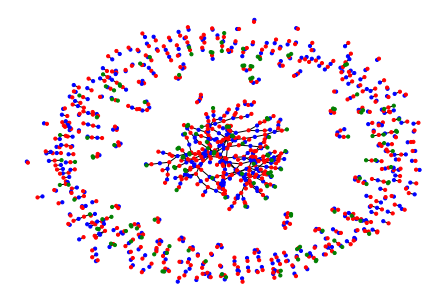

In [9]:
nx.draw(all_relations_nx, node_color=color_map, node_size = 10)

## Analyzing Networks

The networkx module also has built in tools to analyse graphs. The following measurements are used to assess how the nodes are related to each other in the graph database.

### Network Measures 

The following are some examples of traits of individual nodes and the overall network in a network graph that can be used to characterize network data:

- **Degree Centrality** - counts the number of edges that an individual node has 

    - Nodes with a high degree of connections usually play an important role in a network
    - This can also be looked at in aggregate for all nodes in a graph to get an idea of the overall connectedness of the graph.  For example, calculate the mean and median degree centrality across all nodes to look at how connected a graph is, in general.

- **Betweenness** - indicator of a node's centality in a network. 

    - Equal to the number of shortest paths from all vertices to all others that pass through that node
    - This also can be looked at in aggregate to characterize an entire network.

- **Diameter** - The longest shortest path over all pairs of nodes 

    - Often we want to find the shortest distance between two nodes; the diameter is the longest of these paths 
     - Nodes that occur on many shortest paths between other nodes in the graph have a high betweenness centrality score

- **Cliques** - A clique is a subset of vertices of an undirected graph such that every two distinct vertices in the clique are adjacent.

The functions below are written for your conviencence by http://www.slideshare.net/arnicas/a-quick-and-dirty-intro-to-networkx-and-d3

In [10]:
def calculate_degree_centrality(graph):
    ''' 
    Calculate degree centrality of a node, sets value on node as attribute; returns graph, and dict of the degree centrality values.
	Also has code to print the top 10 nodes by degree centrality to console
    
    Parameters
    ----------
    graph - A Networkx object Graph 
	'''
    g = graph
    dc = nx.degree_centrality(g)
    nx.set_node_attributes(g, dc, 'degree_centrality')
    degcent_sorted = sorted(dc.items(), key = operator.itemgetter(1), reverse = True)
    for key, value in degcent_sorted[0:10]:
        print( "Highest degree Centrality:" + str( key ) + " - " + str( value ) )
    return graph, dc 


In [11]:
def calculate_betweenness(graph):
    ''' 
    Calculate betweenness centrality of a node, sets value on node as attribute; returns graph, and dict of the betweenness centrality values

    Parameters
    ----------
    graph - A Networkx object Graph 
    '''
    g = graph
    bc=nx.betweenness_centrality(g)
    nx.set_node_attributes(g,bc,'betweenness')
    degcent_sorted = sorted(bc.items(), key = operator.itemgetter(1), reverse = True)
    for key, value in degcent_sorted[0:10]:
        print( "Highest Betweeness:" + str( key ) + " - " + str( value ) )
    return g #, bc



In [12]:
def find_cliques(graph):
	''' 
    Calculate cliques and return as sorted list.  Print sizes of cliques found.
    
    Parameters
    ----------
    graph - A Networkx object Graph 
	'''
	g = graph
	cl = nx.find_cliques(g)
	cl = sorted(list( cl ), key=len, reverse=True)
	print( "Number of cliques: " + str( len(cl) ) )
	cl_sizes = [len(c) for c in cl]
	print( "Size of cliques:" + str( cl_sizes ) )
	return cl



In [13]:
def find_diameter(graph):
    """
    Calculate the Diameter of a graph
    
    Parameters
    ----------
    graph - A Networkx object Graph    
    """
    diameter = nx.diameter(graph)
    print( "Diameter: " + str( diameter ) )
    return diameter



We can find the centrality measures and find cliques by calling the functions above.

In [14]:
print( "_________________DEGREE CENTRALITY ________________" )
calculate_degree_centrality( all_relations_nx )
print( "_________________Betweenness ________________" )
calculate_betweenness( all_relations_nx )
print( "_________________Cliques ________________" )
find_cliques( all_relations_nx )
print( "__________________________________________" )

_________________DEGREE CENTRALITY ________________
Highest degree Centrality:aw1261 - 0.00505050505050505
Highest degree Centrality:aw1007 - 0.003367003367003367
Highest degree Centrality:aw1008 - 0.003367003367003367
Highest degree Centrality:aw1009 - 0.003367003367003367
Highest degree Centrality:aw1010 - 0.003367003367003367
Highest degree Centrality:aw1011 - 0.003367003367003367
Highest degree Centrality:aw1012 - 0.003367003367003367
Highest degree Centrality:aw1022 - 0.003367003367003367
Highest degree Centrality:aw1023 - 0.003367003367003367
Highest degree Centrality:aw1027 - 0.003367003367003367
_________________Betweenness ________________
Highest Betweeness:aw1012 - 0.0094897302142458
Highest Betweeness:aw1013 - 0.00943441718504903
Highest Betweeness:aw1014 - 0.009376267590252426
Highest Betweeness:aw1015 - 0.009228766179061041
Highest Betweeness:1646 - 0.008959292447076777
Highest Betweeness:90008389 - 0.008902561135080091
Highest Betweeness:90024642 - 0.008806117904685723
H

### Plotting Network Metrics

Betweeness and Centrality are both measures on how connnected a node is to its surounding nodes. However, they measure connectiveness in slightly different ways. A Node with high Degree centrality does not nessasarily mean the node also has a high level a Betwennness Centrality.

   A node with high betweenness but low degree might indicated that a node's few connections are critical to the shape of the graph

   A node with high degree but low betweenness might indicate that a node's connections are redundent and connections can bypass that node
    
We can investigate this further by plotting degree centrality with betweenness centrality to see the relationship.

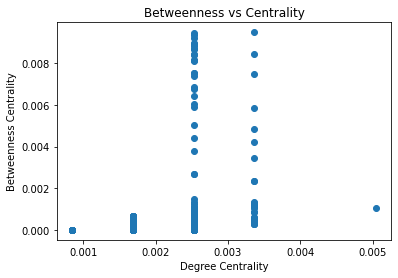

In [16]:
dc_data = list( nx.degree_centrality( all_relations_nx ).values() )
bw_data = list( nx.betweenness_centrality( all_relations_nx ).values() )

x = dc_data
y = bw_data

plt.scatter(x, y)

#title
plt.title("Betweenness vs Centrality")

#labels
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.show()

## Analysing Graphs


We can also create histograms of the degree centrality and betweenness centrality to look at the distributions.

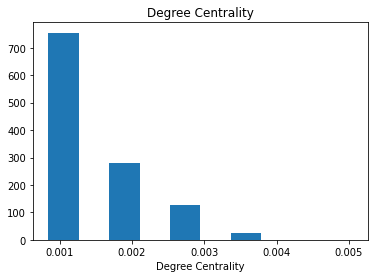

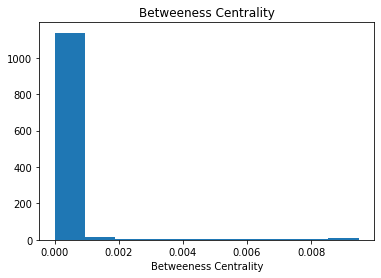

In [19]:
# Your soultion should Look somthing Like this 

def graph_data(graph):
    """
    Creates histograms of the the Degree of Centrality and the Betweenness Centrality 
    
    Parameters
    ----------
    graph - A Networkx object Graph. Graph nodes must have degree_centrality and betweenness attributes
    
    """
    # Create an empty list to hold all of our degree_centrality items  
    cen_list = []
    # Use the built in function get_node_attributes to collect the degree_centrality for each node
    for item in nx.get_node_attributes(graph, 'degree_centrality'):
        cen_list.append(nx.get_node_attributes(graph, 'degree_centrality')[item])
    
    # Pass the cen_list to a plt object and plot as a histogram 
    plt.figure(1)
    #title
    plt.title("Degree Centrality")

    #labels
    plt.xlabel("Degree Centrality")
    
    plt.hist(cen_list)
    
    # Create an empty list to hold all of our eigen_cent items 
    bw_list = []
    # Use the built in function get_node_attributes to collect the eigen_cent for each node
    for item in nx.get_node_attributes(graph, 'betweenness'):
        bw_list.append(nx.get_node_attributes(graph, 'betweenness')[item])
    
    # Pass the eig_list to a plt object and plot as a histogram 
    plt.figure(2)
    #title
    plt.title("Betweeness Centrality")

    #labels
    plt.xlabel("Betweeness Centrality")
    plt.hist(bw_list)

    
# Call the function graph_data() on our Networkx graph 
graph_data( all_relations_nx )

